In [152]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as NB

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (7, 4)

### 13. This question should be answered using the Weekly data set, which is part of the ISLR2 package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1, 089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

#### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [122]:
weekly_df = pd.read_csv("data\Weekly.csv")
#In the Direction Column 1 -> up : 0 -> down

weekly_df["Direction"] = weekly_df["Direction"].map({"Down": 0, "Up": 1})
weekly_df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,0.555556
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,0.497132
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,0.000000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,0.000000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,1.000000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,1.000000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000,1.000000


We see that the lag values are similar

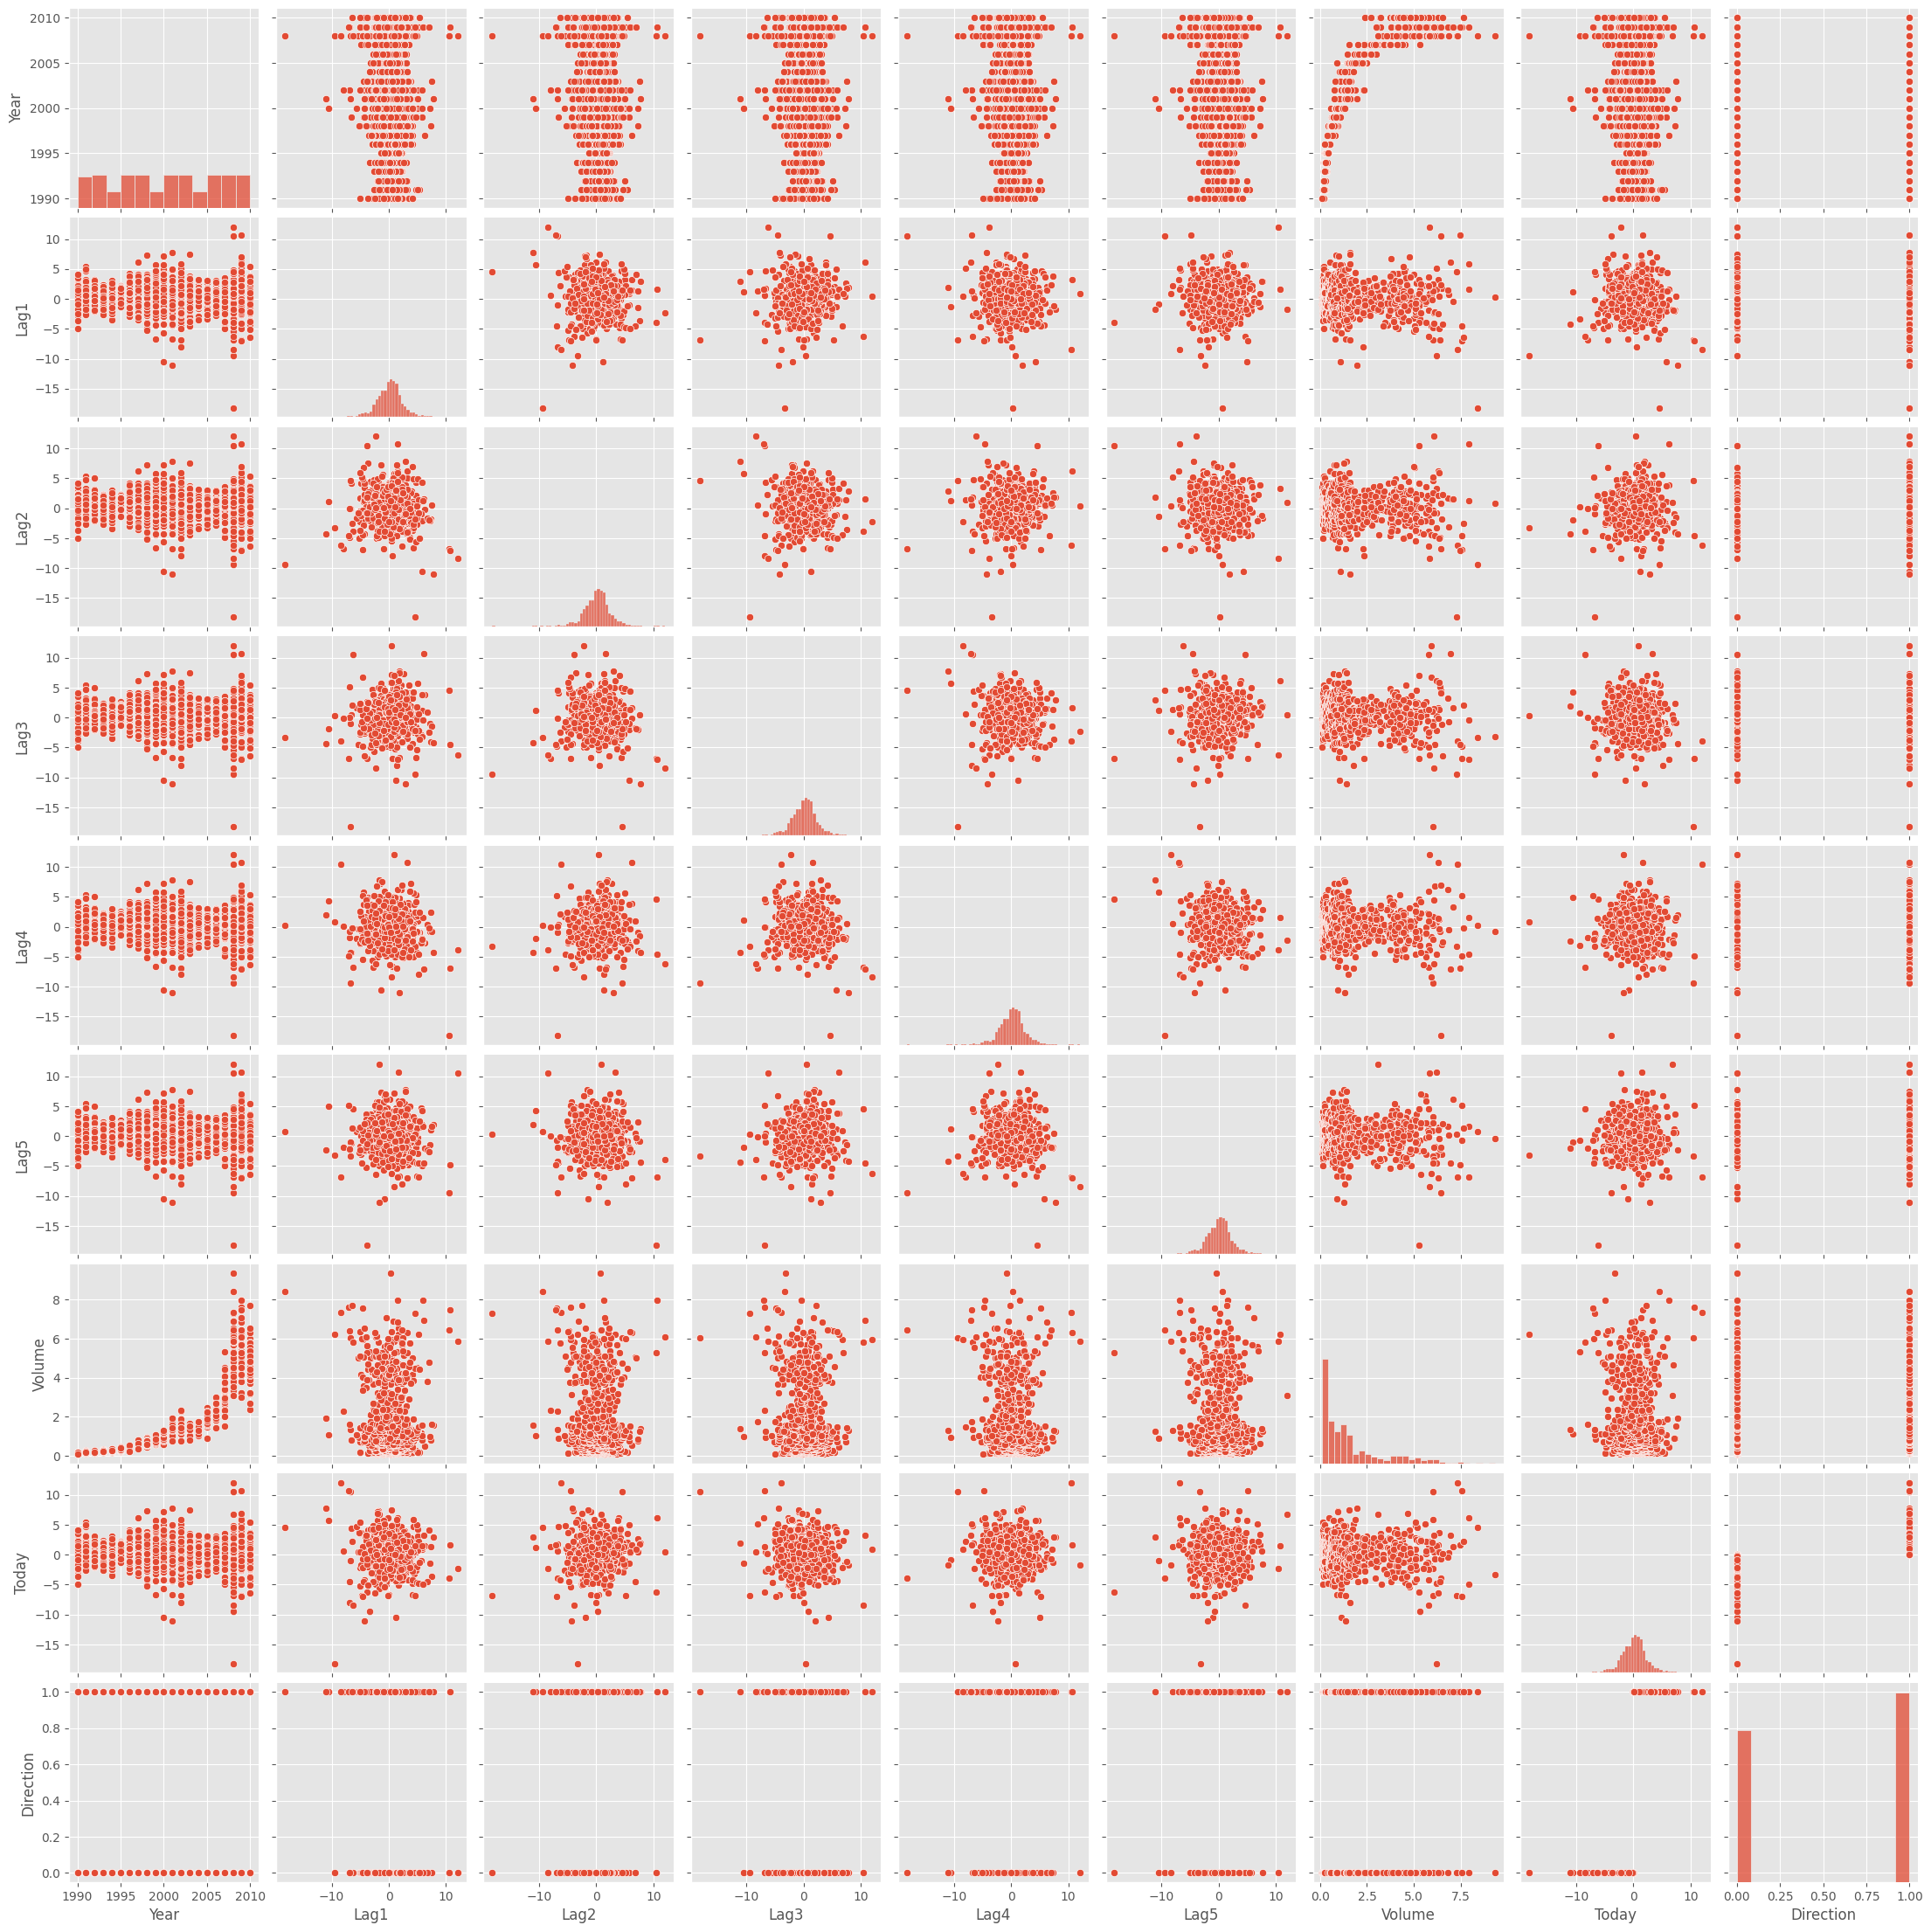

In [123]:
sns.pairplot(weekly_df)

<AxesSubplot: >

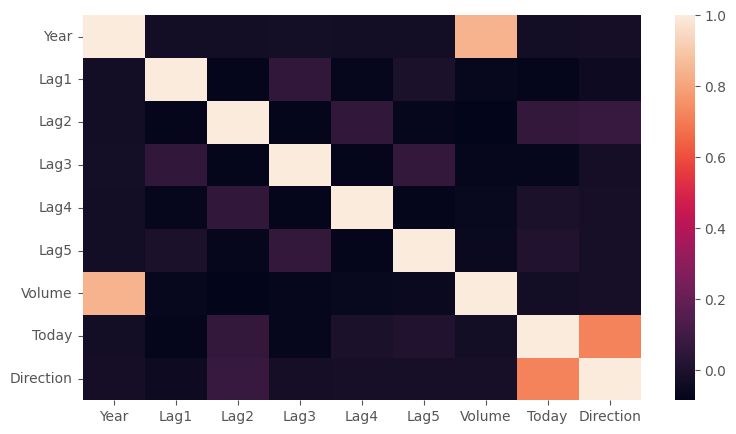

In [124]:
corrs = weekly_df.corr()
sns.heatmap(corrs)

We see some discernable relationship between volume and year

#### (b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [125]:
y = weekly_df.Direction
feats = ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]
X = weekly_df[feats]
X = sm.add_constant(X)

logit_model = sm.Logit(y, X).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Aug 2023   Pseudo R-squ.:                0.006580
Time:                        21:24:39   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

The only statistically significant predictor is the Lag2 variable.

#### (c) Compute the confusion matrix and overall fraction of correctpredictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

Accuracy       0.561065
Precision      0.564336
Recall         0.920661
Specificity    0.111570
dtype: float64

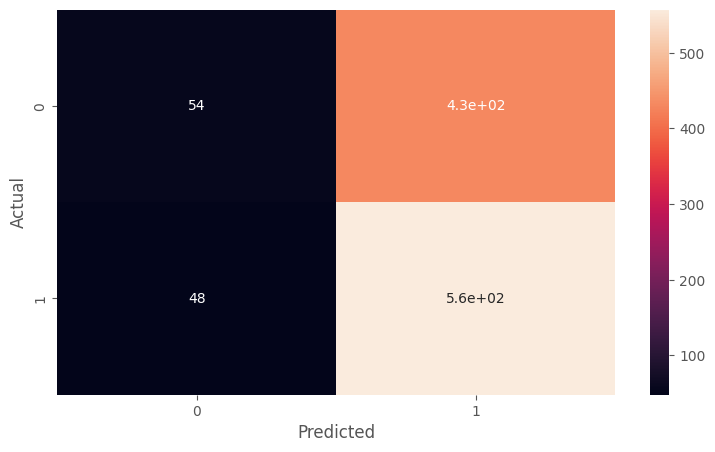

In [126]:
from sklearn.metrics import confusion_matrix
log_fits = logit_model.predict(X)
log_fits = log_fits > 0.5

def print_diag(y, y_preds):
    conf = confusion_matrix(y, y_preds)
    accuracy = (conf[1, 1] + conf[0, 0]) / len(y)
    precision = conf[1, 1] / (conf[1, 1] + conf[0, 1])
    recall = conf[1, 1] / (conf[1, 1] + conf[1, 0])
    specificity = conf[0, 0] / (conf[0, 0] + conf[0, 1])
    
    sns.heatmap(conf, annot=True)
    ax = plt.gca()
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    
    res = pd.Series([accuracy, precision, recall, specificity],
                    index=["Accuracy", "Precision", "Recall", "Specificity"]
                   )
    
    return res

print_diag(y, log_fits)

We see from the results that the overall accuracy is not that great at 56%. When the market is up, the model correctly predicts it 92% of the time. When the market is down, the model predicts it only 11% of the time. If the model predicts that the market is up, it is correct 56% of the time.


#### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [134]:
X_train, X_test = X[weekly_df.Year <= 2008], X[weekly_df.Year > 2008]
X_train, X_test = X_train[["Lag2"]], X_test[["Lag2"]]
y_train, y_test = y[weekly_df.Year <= 2008], y[weekly_df.Year > 2008]

Accuracy       0.625000
Precision      0.622222
Recall         0.918033
Specificity    0.209302
dtype: float64

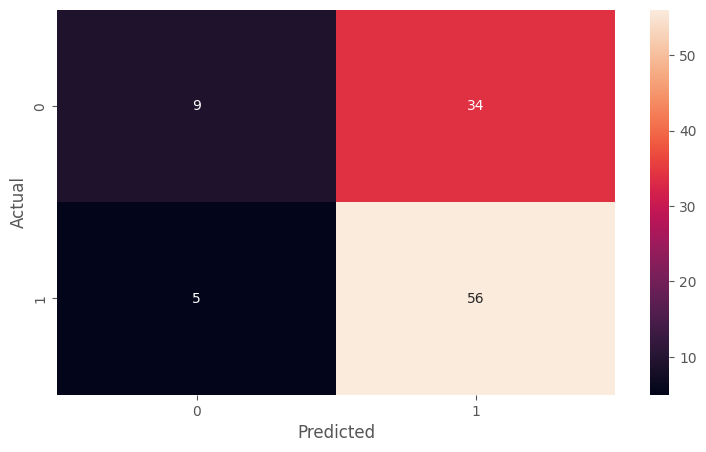

In [135]:
from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression().fit(X_train, y_train)

log_reg_preds = log_reg.predict(X_test) > 0.5
print_diag(y_test, log_reg_preds)

#### (e) Repeat (d) using LDA

Accuracy       0.625000
Precision      0.622222
Recall         0.918033
Specificity    0.209302
dtype: float64

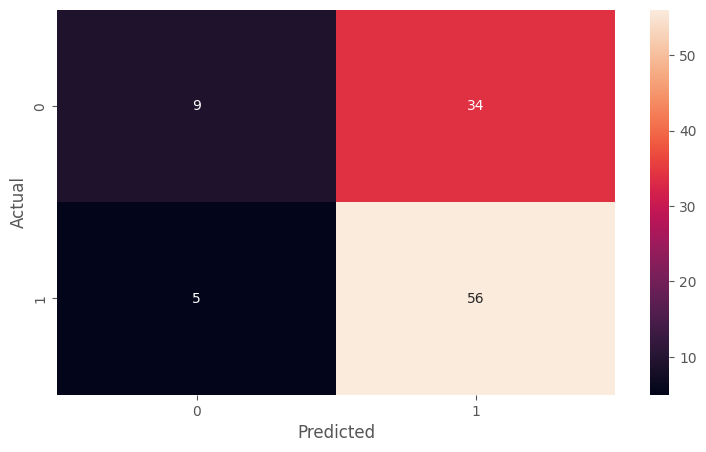

In [136]:
lda_model = LDA()
lda_model.fit(X_train, y_train)

lda_preds = lda_model.predict(X_test)
print_diag(y_test, lda_preds)

#### (f) Repeat (d) using QDA

Accuracy       0.586538
Precision      0.586538
Recall         1.000000
Specificity    0.000000
dtype: float64

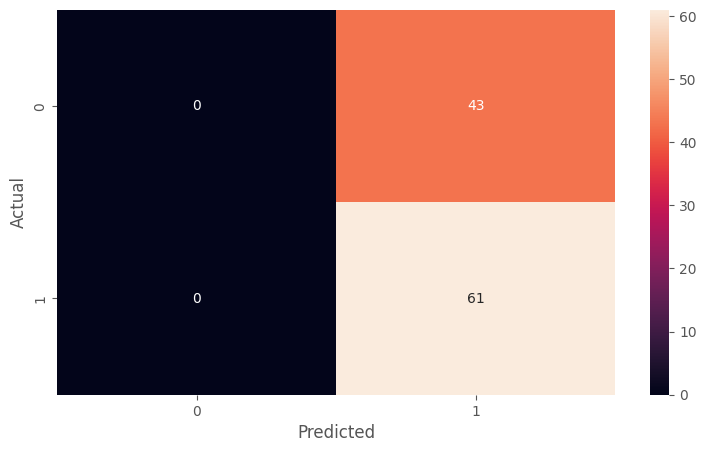

In [137]:
qda = QDA()
qda.fit(X_train, y_train)

qda_preds = qda.predict(X_test)
print_diag(y_test, qda_preds)

#### (g) Repeat (d) using KNN with K = 1

Accuracy       0.509615
Precision      0.596154
Recall         0.508197
Specificity    0.511628
dtype: float64

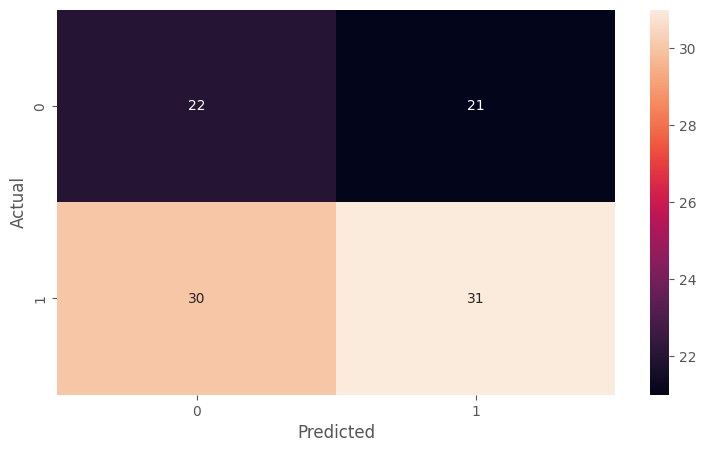

In [138]:
knn = KNN(n_neighbors=1)
knn.fit(X_train, y_train)

knn_preds = knn.predict(X_test)
print_diag(y_test, knn_preds)

#### (g) Repeat (d) using naive Bayes

Accuracy       0.586538
Precision      0.586538
Recall         1.000000
Specificity    0.000000
dtype: float64

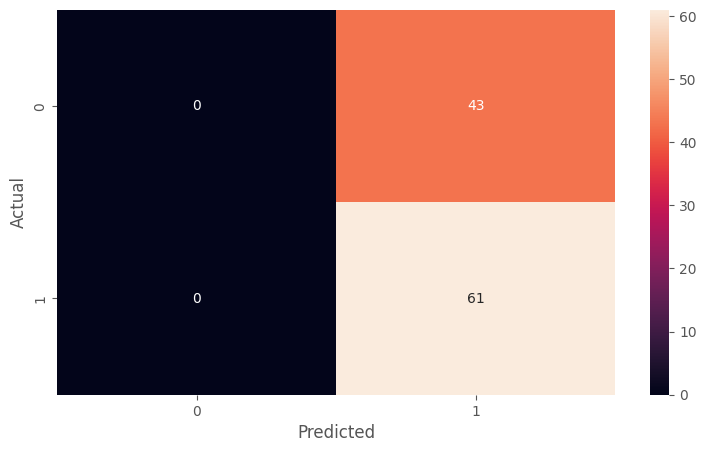

In [139]:
naive_bayes = NB()
naive_bayes.fit(X_train, y_train)

nb_preds = naive_bayes.predict(X_test)
print_diag(y_test, nb_preds)

#### (i) Which of these methods appears to provide the best results on this data?
The models that have the best out-of-sample Accuracy, Recall, and Precision are the Logit and LDA model.


#### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [140]:
from sklearn.preprocessing import PolynomialFeatures
X_train = weekly_df[weekly_df.Year < 2009][feats[:-1]]
X_test = weekly_df[weekly_df.Year >= 2009][feats[:-1]]

poly_trans = PolynomialFeatures()
X_train = pd.DataFrame(poly_trans.fit_transform(X_train), columns=poly_trans.get_feature_names_out())
X_test = pd.DataFrame(poly_trans.transform(X_test), columns=poly_trans.get_feature_names_out())

### 14. In this problem, you will develop a model to predict whether a given car gets high or low gas milegage based on the Auto data set.

#### (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() function. Note you may find it helpful to use the data.frame() function to create a single data set containing both mpg01 and the other Auto variables.

In [141]:
auto_df = pd.read_csv("data/auto_v2.csv", index_col=0)
map_ = lambda x: 0 if x is False else 1

y = (auto_df.mpg > auto_df.mpg.median()).map(map_)
X = auto_df.drop(["mpg", "name"], axis=1)

#### (a) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the otherfeatures seem most likely to be useful in predicting mpg01 Scatterplots and boxplots may be useful tools to answer this question.  Describe your findings.

<AxesSubplot: >

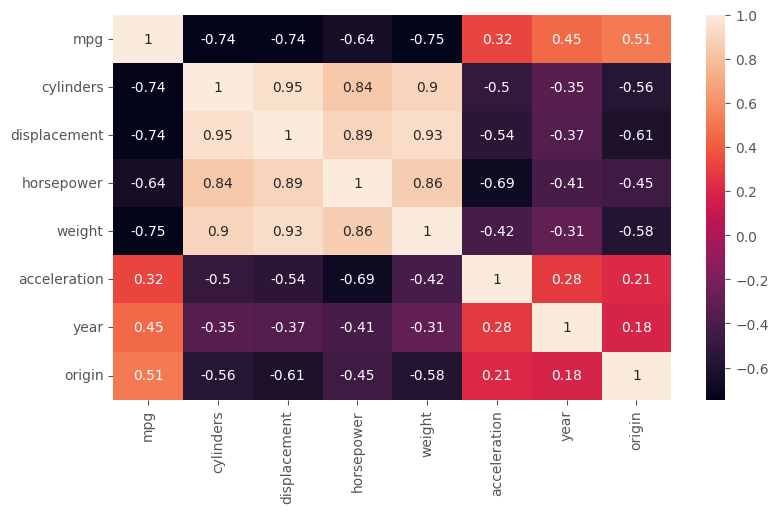

In [142]:
auto_df_ = auto_df.drop("name", axis=1)
auto_df_.mpg = y
sns.heatmap(auto_df_.corr(numeric_only=True), annot=True)

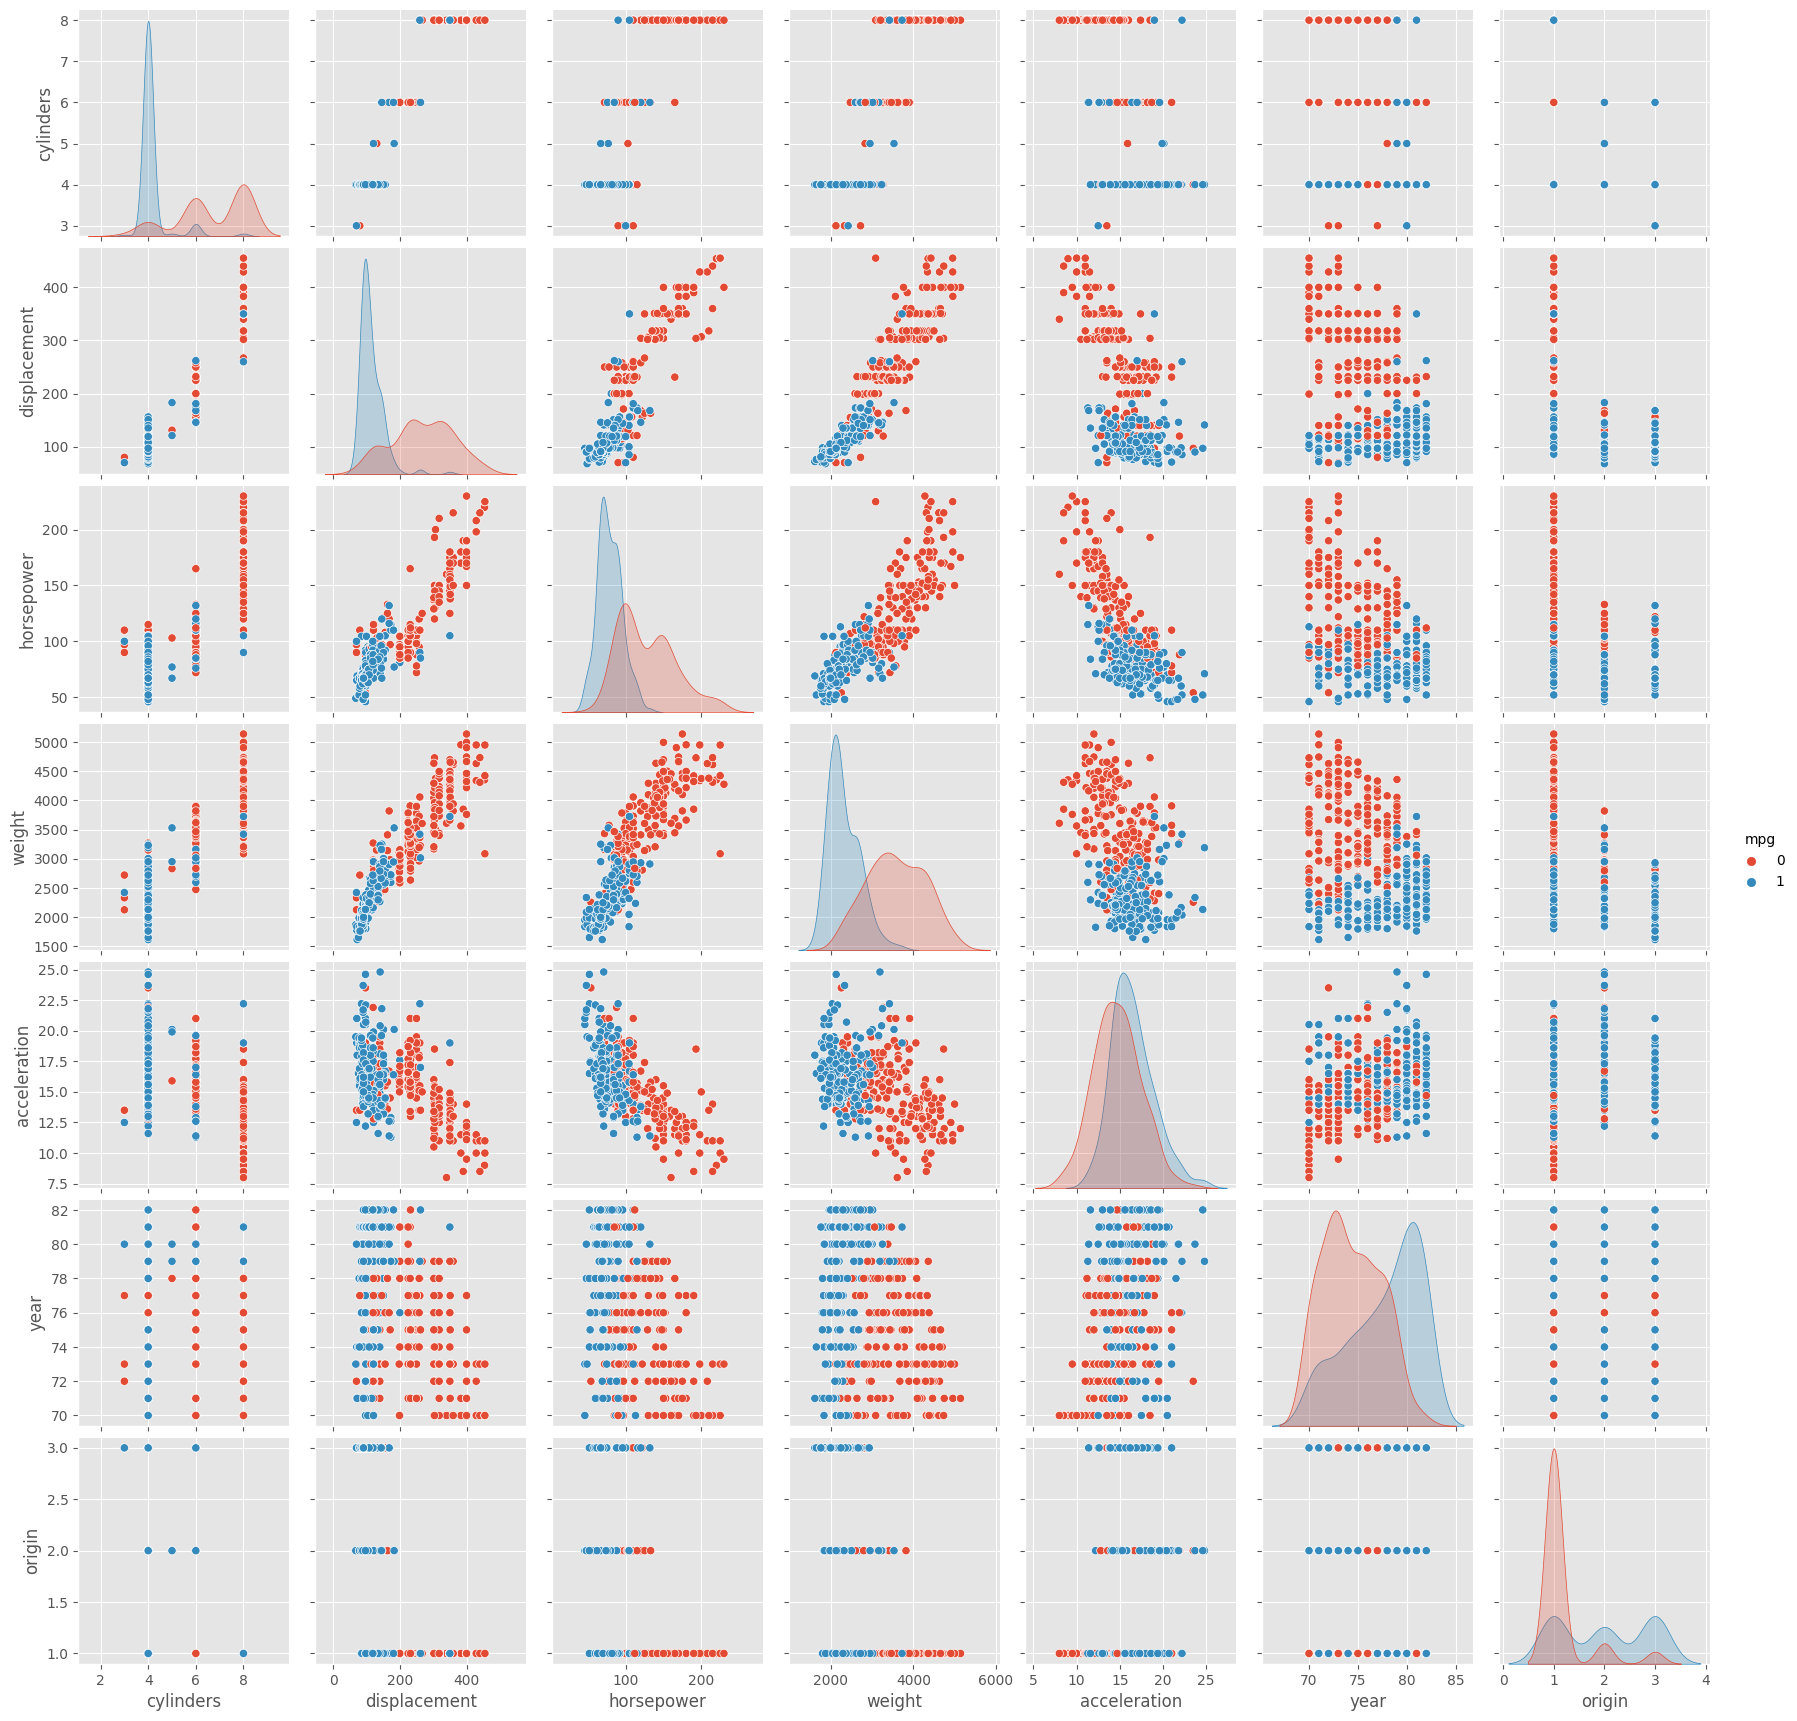

In [156]:
sns.pairplot(auto_df_, hue="mpg")

We see from the results that cylinders, weight and displacement are the most prominent features. Although we also see that acceleration, year and origin could also be good predictors.

#### (c) Split the data into a training set and a test set.

In [170]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

def create_eval(model, X_train, X_test, y_train, y_test, ax=None):
    model = model.fit(X_train, y_train)
    model_preds = model.predict(X_test)
    
    diag = print_diag(y_test, model_preds)
    return diag

#### (d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

Accuracy       0.900000
Precision      0.864407
Recall         0.962264
Specificity    0.829787
dtype: float64

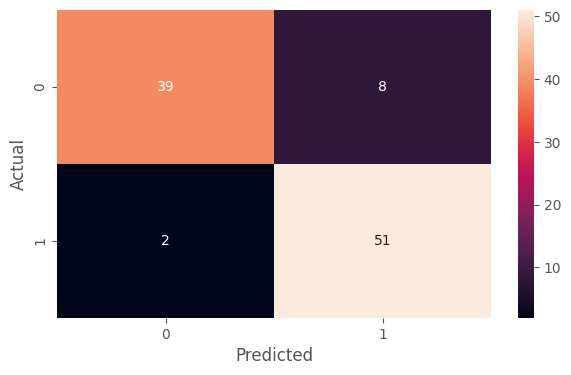

In [171]:
create_eval(LDA(), X_train, X_test, y_train, y_test)

#### (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

Accuracy       0.890000
Precision      0.903846
Recall         0.886792
Specificity    0.893617
dtype: float64

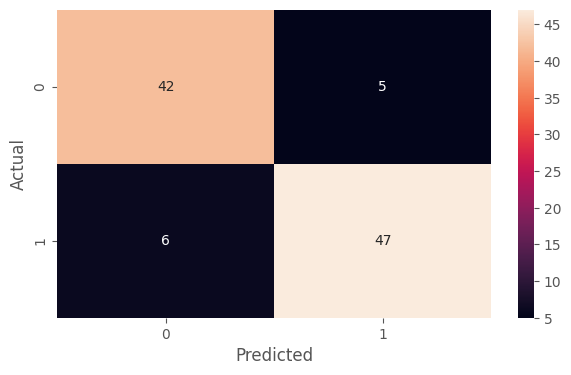

In [172]:
create_eval(QDA(), X_train, X_test, y_train, y_test)

#### (f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

Accuracy       0.920000
Precision      0.924528
Recall         0.924528
Specificity    0.914894
dtype: float64

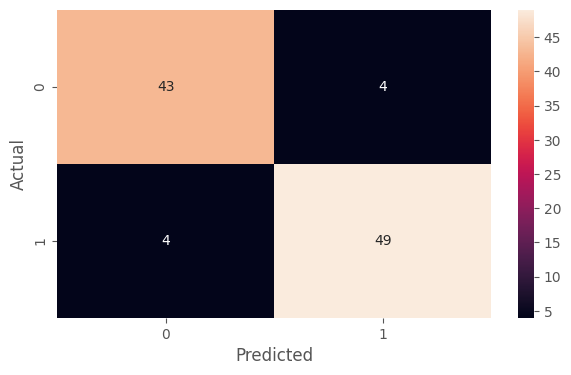

In [178]:
create_eval(LogisticRegression(max_iter=500), X_train, X_test, y_train, y_test)

#### (g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

Accuracy       0.870000
Precision      0.844828
Recall         0.924528
Specificity    0.808511
dtype: float64

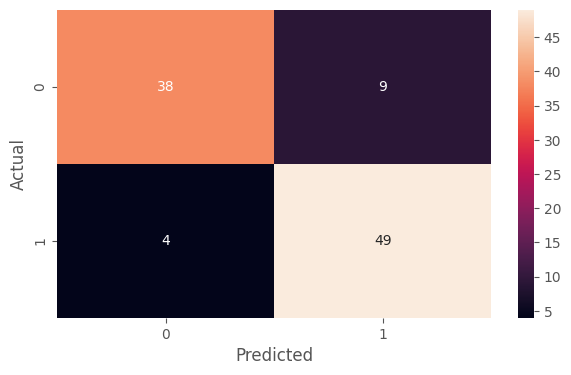

In [180]:
create_eval(NB(), X_train, X_test, y_train, y_test)

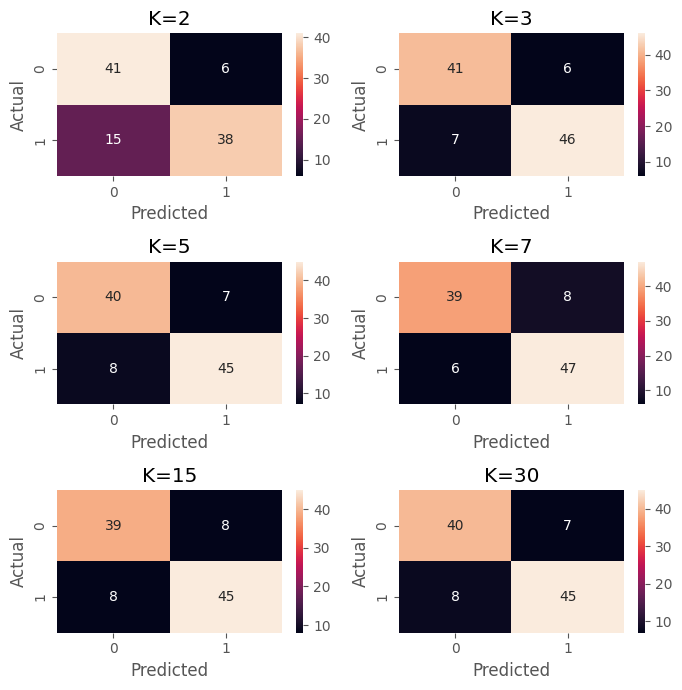

In [200]:
fig = plt.figure(figsize=(7,7))


fig.add_subplot(321)
create_eval(KNN(n_neighbors=2), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=2")

fig.add_subplot(323)
create_eval(KNN(n_neighbors=5), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=5")
            
fig.add_subplot(324)
create_eval(KNN(n_neighbors=7), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=7")

fig.add_subplot(325)
create_eval(KNN(n_neighbors=15), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=15")

fig.add_subplot(326)
create_eval(KNN(n_neighbors=30), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=30")


fig.add_subplot(322)
create_eval(KNN(n_neighbors=3), X_train, X_test, y_train, y_test)
ax = plt.gca()
ax.set_title("K=3")

plt.tight_layout()

It seems like k=3 is the best choice for the KNN classifier. We see that we overfit at k=2 and the performance levels out at K > 3